# APS360 Project

1. Load and split data for training, validation and testing
2. Creating Generator
3. Creating Discriminator
4. Training



## Part A. Data Loading

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
import os
import shutil
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.nn.utils import spectral_norm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
BATCH_SIZE = 1
LEARNING_RATE = 0.0003
LAMBDA_IDENTITY = 0.0  # loss weight for identity loss
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 50
PM = 64
USE_DROPOUT = True
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_GENERATOR_ANIME = "models/gen_anime"
CHECKPOINT_GENERATOR_HUMAN = "models/gen_human"
CHECKPOINT_DISCRIMINATOR_ANIME = "models/disc_anime"
CHECKPOINT_DISCRIMINATOR_HUMAN = "models/disc_human"


transforms = A.Compose(
    [
        A.Resize(width=128, height=128),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
        
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5],max_pixel_value=255),
        
    ],
    additional_targets={"image0": "image"},
)


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


### 0. Helper Functions ###

In [2]:
###############################################################################
# Data Loading
import os
import random
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler



class ImageBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), "Empty buffer"
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)


class AnimeHumanImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, fname))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)  # Convert to NumPy array for albumentations
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, 0  # Since there are no labels, we can return a dummy label (0)
    

def create_subset_dataset(original_dir, subset_dir, subset_size=100):
    """
    Creates a subset of the original dataset.
    
    Args:
        original_dir (str): Path to the original dataset directory.
        subset_dir (str): Path to the subset dataset directory.
        subset_size (int): Number of images to include in the subset.
    """
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)
    else:
        # Clear the subset directory
        for filename in os.listdir(subset_dir):
            file_path = os.path.join(subset_dir, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
    
    # Get all image paths
    image_paths = [os.path.join(original_dir, fname) for fname in os.listdir(original_dir) if os.path.isfile(os.path.join(original_dir, fname))]
    
    # Shuffle and select a subset
    np.random.seed(1000)
    np.random.shuffle(image_paths)
    subset_paths = image_paths[:subset_size]
    
    # Copy images to the subset directory
    for img_path in subset_paths:
        shutil.copy(img_path, subset_dir)

    print(f"Subset created with {len(subset_paths)} images in {subset_dir}")

def get_data_loader(data_dir, batch_size, image_size=(128, 128), subset_size=None):
   # Define the transformation
    transform = A.Compose([
        A.Resize(width=image_size[0], height=image_size[1]),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2(),
    ])
    
    # Verify the path
    assert os.path.exists(data_dir), f"Directory not found: {data_dir}"

    # Load the dataset
    dataset = AnimeHumanImageDataset(root_dir=data_dir, transform=transform)

    # Use a subset of the dataset if specified
    if subset_size:
        num_images = len(dataset)
        indices = list(range(num_images))
        np.random.seed(1000)
        np.random.shuffle(indices)
        subset_indices = indices[:subset_size]
        subset_sampler = SubsetRandomSampler(subset_indices)
        loader = DataLoader(dataset, batch_size=batch_size, sampler=subset_sampler, num_workers=1)
        return loader

    # Function to split dataset indices
    def split_indices(dataset):
        num_images = len(dataset)
        indices = list(range(num_images))
        np.random.seed(1000)  # Setting a seed for reproducibility
        np.random.shuffle(indices)

        train_split = int(0.7 * num_images)
        val_split = int(0.15 * num_images)

        train_indices = indices[:train_split]
        val_indices = indices[train_split:train_split + val_split]
        test_indices = indices[train_split + val_split:]

        return train_indices, val_indices, test_indices

    # Get split indices for the dataset
    train_indices, val_indices, test_indices = split_indices(dataset)

    # Create data loaders
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=1)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=1)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=1)

    return train_loader, val_loader, test_loader

def verify_splits_and_check_overlaps(train_loader_A, val_loader_A, test_loader_A, train_loader_B, val_loader_B, test_loader_B):
    # Verify the split sizes for dataset A
    total_examples_A = len(train_loader_A.sampler) + len(val_loader_A.sampler) + len(test_loader_A.sampler)
    train_size_A = len(train_loader_A.sampler)
    val_size_A = len(val_loader_A.sampler)
    test_size_A = len(test_loader_A.sampler)

    train_proportion_A = train_size_A / total_examples_A
    val_proportion_A = val_size_A / total_examples_A 
    test_proportion_A = test_size_A / total_examples_A

    print(f"Dataset A - Total examples: {total_examples_A}")
    print(f"Dataset A - Train examples: {train_size_A} ({train_proportion_A:.2%})")
    print(f"Dataset A - Validation examples: {val_size_A} ({val_proportion_A:.2%})")
    print(f"Dataset A - Test examples: {test_size_A} ({test_proportion_A:.2%})")

    # Verify the split sizes for dataset B
    total_examples_B = len(train_loader_B.sampler) + len(val_loader_B.sampler) + len(test_loader_B.sampler)
    train_size_B = len(train_loader_B.sampler)
    val_size_B = len(val_loader_B.sampler)
    test_size_B = len(test_loader_B.sampler)

    train_proportion_B = train_size_B / total_examples_B
    val_proportion_B = val_size_B / total_examples_B 
    test_proportion_B = test_size_B / total_examples_B

    print(f"Dataset B - Total examples: {total_examples_B}")
    print(f"Dataset B - Train examples: {train_size_B} ({train_proportion_B:.2%})")
    print(f"Dataset B - Validation examples: {val_size_B} ({val_proportion_B:.2%})")
    print(f"Dataset B - Test examples: {test_size_B} ({test_proportion_B:.2%})")

    # Check for overlaps in dataset A
    train_indices_A = list(train_loader_A.sampler.indices)
    val_indices_A = list(val_loader_A.sampler.indices)
    test_indices_A = list(test_loader_A.sampler.indices)
    print("Checking overlaps for dataset A...")
    check_for_overlaps(train_indices_A, val_indices_A, test_indices_A)

    # Check for overlaps in dataset B
    train_indices_B = list(train_loader_B.sampler.indices)
    val_indices_B = list(val_loader_B.sampler.indices)
    test_indices_B = list(test_loader_B.sampler.indices)
    print("Checking overlaps for dataset B...")
    check_for_overlaps(train_indices_B, val_indices_B, test_indices_B)

def check_for_overlaps(train_indices, val_indices, test_indices):
    # Convert indices to sets
    train_indices_set = set(train_indices)
    val_indices_set = set(val_indices)
    test_indices_set = set(test_indices)

    # Check for overlaps
    train_val_overlap = train_indices_set.intersection(val_indices_set)
    train_test_overlap = train_indices_set.intersection(test_indices_set)
    val_test_overlap = val_indices_set.intersection(test_indices_set)

    # Print the results
    print(f"Train/Validation Overlap: {len(train_val_overlap)} indices")
    print(f"Train/Test Overlap: {len(train_test_overlap)} indices")
    print(f"Validation/Test Overlap: {len(val_test_overlap)} indices")

    if not train_val_overlap and not train_test_overlap and not val_test_overlap:
        print("No overlaps found between train, validation, and test sets.")
    else:
        print("Overlaps detected. Please check the data splitting logic.")

###############################################################################
# Training
import glob

def evaluate(generator, discriminator, loader, criterion, device):
    generator.eval()
    discriminator.eval()
    
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs = inputs.to(device)
            
            # Generate fake images
            fake_images = generator(inputs)
            outputs = discriminator(fake_images)
            
            # Calculate loss
            loss = criterion(outputs, torch.ones_like(outputs).to(device))
            total_loss += loss.item()
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    return avg_loss


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    print(f"=> Saving checkpoint to {filename}")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_latest_checkpoint(model, optimizer, checkpoint_prefix, lr, batch_size):
    checkpoint_files = glob.glob(f"{checkpoint_prefix}_lr{lr}_bs{batch_size}_epoch_*.pth.tar")
    if not checkpoint_files:
        print(f"=> No checkpoint found for {checkpoint_prefix}. Starting from scratch.")
        return 0

    # Extract the latest epoch number from the checkpoint file names
    latest_epoch = max([int(file.split('_')[-1].split('.')[0]) for file in checkpoint_files])
    checkpoint_file = f"{checkpoint_prefix}_lr{lr}_bs{batch_size}_epoch_{latest_epoch}.pth.tar"

    print(f"=> Loading checkpoint {checkpoint_file}")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    return latest_epoch + 1

def get_model_name(model_type, epoch, learning_rate, batch_size):
    return f"models/{model_type}_lr{learning_rate}_bs{batch_size}_epoch_{epoch}.pth.tar"

def list_checkpoints(checkpoint_prefix):
    checkpoint_pattern = os.path.join(f"{checkpoint_prefix}_epoch_*.pth.tar")
    checkpoint_files = glob.glob(checkpoint_pattern)
    
    if not checkpoint_files:
        print(f"No checkpoint found for prefix: {checkpoint_prefix}")
    else:
        print(f"Checkpoints found for prefix {checkpoint_prefix}:")
        for checkpoint in checkpoint_files:
            print(checkpoint)
            
def save_losses(train_loss_anime_history, train_loss_human_history, val_loss_anime_history, val_loss_human_history, path_prefix):
    np.savetxt(f"{path_prefix}_train_loss_anime.csv", train_loss_anime_history)
    np.savetxt(f"{path_prefix}_train_loss_human.csv", train_loss_human_history)
    np.savetxt(f"{path_prefix}_val_loss_anime.csv", val_loss_anime_history)
    np.savetxt(f"{path_prefix}_val_loss_human.csv", val_loss_human_history)


###############################################################################
# Training Curve
def plot_training_curve(path):
    import matplotlib.pyplot as plt
    train_loss_anime_file = f"{path}_train_loss_anime.csv"
    train_loss_human_file = f"{path}_train_loss_human.csv"
    val_loss_anime_file = f"{path}_val_loss_anime.csv"
    val_loss_human_file = f"{path}_val_loss_human.csv"

    train_loss_anime = np.loadtxt(train_loss_anime_file)
    train_loss_human = np.loadtxt(train_loss_human_file)
    val_loss_anime = np.loadtxt(val_loss_anime_file)
    val_loss_human = np.loadtxt(val_loss_human_file)

    plt.figure()
    plt.title("Train vs Validation Loss (Anime)")
    n = len(train_loss_anime)  # number of epochs
    plt.plot(range(1, n + 1), train_loss_anime, label="Train Anime")
    plt.plot(range(1, n + 1), val_loss_anime, label="Validation Anime")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.figure()
    plt.title("Train vs Validation Loss (Human)")
    plt.plot(range(1, n + 1), train_loss_human, label="Train Human")
    plt.plot(range(1, n + 1), val_loss_human, label="Validation Human")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

### 1.1 Load Data ###

In [7]:
# # Use (1000k photos) smaller subsets for quick testing
# create_subset_dataset('/home/shirwee/documents/aps360-project/data/dataSetA_10k_cropped', 'data/subset_dataSetA_cropped', subset_size=1000)
# create_subset_dataset('/home/shirwee/documents/aps360-project/data/dataSetB_10k', 'data/subset_dataSetB', subset_size=1000)

# # Load data from the subsets
# train_loader_A, val_loader_A, test_loader_A = get_data_loader('data/subset_dataSetA_cropped', BATCH_SIZE, image_size=(128, 128))
# train_loader_B, val_loader_B, test_loader_B = get_data_loader('data/subset_dataSetB', BATCH_SIZE, image_size=(128, 128))

Subset created with 1000 images in data/subset_dataSetA_cropped
Subset created with 1000 images in data/subset_dataSetB


In [3]:
#Load data from the full datasets
train_loader_A, val_loader_A, test_loader_A = get_data_loader('/home/shirwee/documents/aps360-project/data/dataSetA_10k', BATCH_SIZE, image_size=(128, 128))
train_loader_B, val_loader_B, test_loader_B = get_data_loader('/home/shirwee/documents/aps360-project/data/dataSetB_10k', BATCH_SIZE, image_size=(128, 128))

In [4]:
import torch
from skimage.util import random_noise
from torch.utils.data import DataLoader, TensorDataset

def add_gaussian_noise(images, mean=0, std=0.5):
    """
    Add Gaussian noise to the images.
    """
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    return noisy_images

def create_noisy_dataloader(train_loader):
    """
    Create a DataLoader with added Gaussian noise to the images.
    """
    noisy_images = []
    labels = []

    for images, label in train_loader:
        noisy_img = add_gaussian_noise(images)
        noisy_images.append(noisy_img)
        labels.append(label)
    
    noisy_images = torch.cat(noisy_images)
    labels = torch.cat(labels)
    
    noisy_dataset = TensorDataset(noisy_images, labels)
    noisy_dataloader = DataLoader(noisy_dataset, batch_size=train_loader.batch_size, shuffle=True)
    
    return noisy_dataloader

# Assuming you have train_loader_A, train_loader_B, ..., train_loader_F
train_loader_A_noise = create_noisy_dataloader(train_loader_A)
val_loader_A_noise = create_noisy_dataloader(val_loader_A)
test_loader_A_noise = create_noisy_dataloader(test_loader_A)
train_loader_B_noise = create_noisy_dataloader(train_loader_B)
val_loader_B_noise = create_noisy_dataloader(val_loader_B)
test_loader_B_noise = create_noisy_dataloader(test_loader_B)

### 1.2 Verifying Split and Overlap ###

In [5]:
# Check for overlaps
verify_splits_and_check_overlaps(train_loader_A, val_loader_A, test_loader_A, train_loader_B, val_loader_B, test_loader_B)

Dataset A - Total examples: 10000
Dataset A - Train examples: 7000 (70.00%)
Dataset A - Validation examples: 1500 (15.00%)
Dataset A - Test examples: 1500 (15.00%)
Dataset B - Total examples: 10000
Dataset B - Train examples: 7000 (70.00%)
Dataset B - Validation examples: 1500 (15.00%)
Dataset B - Test examples: 1500 (15.00%)
Checking overlaps for dataset A...
Train/Validation Overlap: 0 indices
Train/Test Overlap: 0 indices
Validation/Test Overlap: 0 indices
No overlaps found between train, validation, and test sets.
Checking overlaps for dataset B...
Train/Validation Overlap: 0 indices
Train/Test Overlap: 0 indices
Validation/Test Overlap: 0 indices
No overlaps found between train, validation, and test sets.


### 1.3 Visualize Data ###

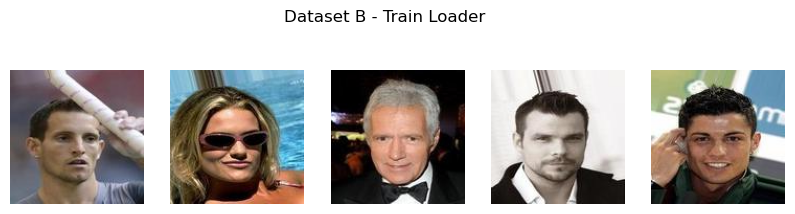

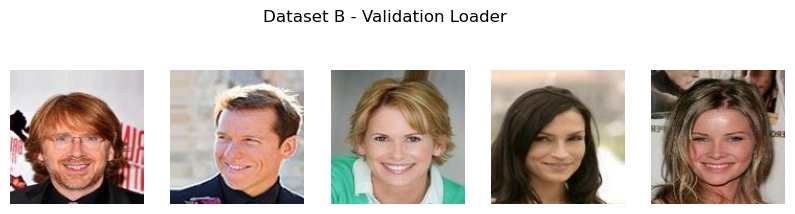

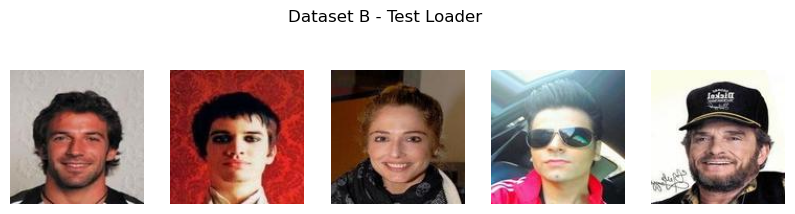

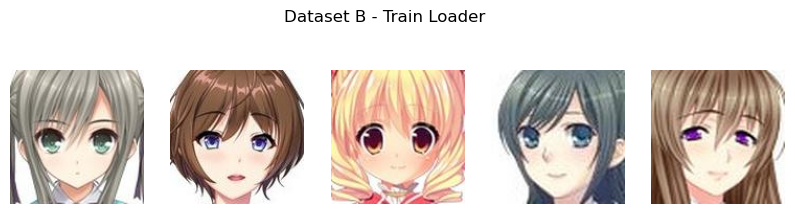

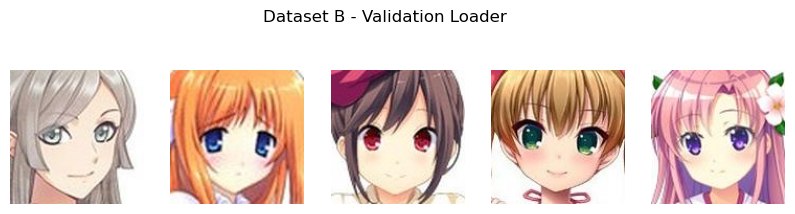

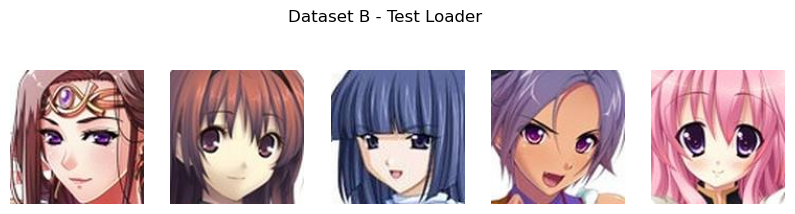

In [6]:
import matplotlib.pyplot as plt

# Taken from Lab 2
def visualize_data_loader(data_loader, title, num_images=5):
    k = 0
    plt.figure(figsize=(10, 6))
    for images, labels in data_loader:
        for i in range(images.size(0)):  
            if k >= num_images:
                break
            image = images[i]
            img = np.transpose(image.numpy(), [1, 2, 0])
            img = img / 2 + 0.5
            plt.subplot(3, 5, k+1)
            plt.axis('off')
            plt.imshow(img)
            k += 1
        if k >= num_images:
            break
    plt.suptitle(title)
    plt.show()

# # Visualize dataset A
# visualize_data_loader(train_loader_A_noise, title="Dataset A - Train Loader")
# visualize_data_loader(val_loader_A_noise, title="Dataset A - Validation Loader")
# visualize_data_loader(test_loader_A_noise, title="Dataset A - Test Loader")

# # Visualize dataset B
# visualize_data_loader(train_loader_B_noise, title="Dataset B - Train Loader")
# visualize_data_loader(val_loader_B_noise, title="Dataset B - Validation Loader")
# visualize_data_loader(test_loader_B_noise, title="Dataset B - Test Loader")


visualize_data_loader(train_loader_A, title="Dataset B - Train Loader")
visualize_data_loader(val_loader_A, title="Dataset B - Validation Loader")
visualize_data_loader(test_loader_A, title="Dataset B - Test Loader")

visualize_data_loader(train_loader_B, title="Dataset B - Train Loader")
visualize_data_loader(val_loader_B, title="Dataset B - Validation Loader")
visualize_data_loader(test_loader_B, title="Dataset B - Test Loader")

## Convolutional Block

In [7]:
import torch
import torch.nn as nn


# Define the reusable convolutional block
class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, is_downsampling: bool = True, add_activation: bool = True, **kwargs):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
                nn.Dropout(0.5)
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
                nn.Dropout(0.5)
            )

    def forward(self, x):
        return self.conv(x)



In [8]:
# Define the residual block using the reusable convolutional block
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, stride=1, padding=1, is_downsampling=False),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, stride=1, padding=1, is_downsampling=False),
        )

    def forward(self, x):
        return x + self.block(x)

In [9]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, pm=64, num_residuals=6):
        super().__init__()
        
        # Initial Layer
        self.initial_layer = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=in_channels, out_channels=pm * 1, kernel_size=7, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(pm * 1),
            nn.ReLU(True)
        )

        # Downsampling
        self.downsampling_layers = nn.Sequential(
            nn.Conv2d(in_channels=pm * 1, out_channels=pm * 2, kernel_size=3, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(pm * 2),
            nn.ReLU(True),
            nn.Conv2d(in_channels=pm * 2, out_channels=pm * 4, kernel_size=3, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(pm * 4),
            nn.ReLU(True)
        )

        # Residual Blocks
        self.residual_layers = nn.Sequential(
            *[ResidualBlock(channels=pm*4) for _ in range(num_residuals)]
        )

        # Upsampling
        self.upsampling_layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=pm * 4, out_channels=pm * 2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
            nn.InstanceNorm2d(pm * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=pm * 2, out_channels=pm * 1, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
            nn.InstanceNorm2d(pm * 1),
            nn.ReLU(True)
        )

        # Final Layer
        self.last_layer = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(pm, out_channels, kernel_size=7, stride=1, padding=0, bias=True),
            nn.Tanh()
        )
            
    def forward(self, x):
        x = self.initial_layer(x)
        x = self.downsampling_layers(x)
        x = self.residual_layers(x)
        x = self.upsampling_layers(x)
        return self.last_layer(x)

In [10]:
# Define the reusable block
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [10]:
# class MiniBatchDiscrimination(nn.Module):
#     def __init__(self, in_features, out_features, kernel_dims=5):
#         super(MiniBatchDiscrimination, self).__init__()
#         self.out_features = out_features
#         self.T = nn.Parameter(torch.randn(in_features, out_features, kernel_dims))

#     def forward(self, x):
#         batch_size = x.size(0)
#         x = x.view(batch_size, -1)  # Flatten the tensor

#         # Compute matrix multiplication
#         M = x.mm(self.T.view(x.size(1), -1))
#         M = M.view(batch_size, self.out_features, self.T.size(2))

#         # Compute L1 distance between each pair of samples in the batch
#         out = M.unsqueeze(0) - M.unsqueeze(1)
#         out = torch.exp(-torch.sum(torch.abs(out), dim=3))

#         # Sum over the kernel dimensions
#         out = out.sum(dim=2)

#         return torch.cat([x, out], dim=1)

In [11]:
# Define the discriminator using the reusable block
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, pm=64):
        super().__init__()
        features = [pm * 1, pm * 2, pm * 4, pm * 8]
        
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(
                    in_channels,
                    feature,
                    stride=2
                )
            )
            in_channels = feature

        # Adjust the last block to match the original structure
        layers.append(
            ConvInstanceNormLeakyReLUBlock(
                in_channels,
                features[-1],
                stride=1
            )
        )

        # Final layer
        layers.append(
            nn.Conv2d(
                in_channels=features[-1],
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect"
            )
        )
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)
        return self.model(x)

In [12]:
import os
import numpy as np
import torch
from torchvision.utils import save_image
from tqdm import tqdm
import itertools

def denormalize(tensor):
    return tensor * 0.5 + 0.5

def train_fn(disc_human, disc_anime, gen_anime, gen_human, train_loader_A, train_loader_B, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler, num_epochs=1, start_epoch=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    torch.cuda.empty_cache()

    train_loss_anime_history = []
    train_loss_human_history = []
    val_loss_anime_history = []
    val_loss_human_history = []

    # Ensure the outputs directory exists
    os.makedirs('outputs/A', exist_ok=True)
    os.makedirs('outputs/B', exist_ok=True)

    for epoch in range(num_epochs):
        current_epoch = start_epoch + epoch
        print(f"Epoch [{current_epoch + 1}/{start_epoch + num_epochs}]")
        epoch_loop = tqdm(zip(train_loader_A, train_loader_B), total=min(len(train_loader_A), len(train_loader_B)), leave=True, desc="Iteration")

        total_train_loss_anime = 0.0
        total_train_loss_human = 0.0
        total_batches = 0

        H_reals = 0
        H_fakes = 0

        # Learning rate decay for over 75 epochs
        if epoch > 75:
            for param_group in opt_gen.param_groups:
                param_group['lr'] *= 0.993
            for param_group in opt_disc.param_groups:
                param_group['lr'] *= 0.993

        for idx, (a_real, b_real) in enumerate(epoch_loop):
            a_real = a_real[0]  # Remove label from imagefolder
            b_real = b_real[0]
            a_real = a_real.to(device)
            b_real = b_real.to(device)
                
            # A: faces
            # B: anime
            # Generators
            
            # -----------------------------
            # Anime Cycle: B -> A' -> B^ === b_real -> a_fake -> b-recon
            # -----------------------------
            
            opt_gen.zero_grad()
            a_fake = gen_anime(b_real)
            a_dis_pred = disc_anime(a_fake)
            
            # Create a truth label
            label_1 = torch.ones(a_dis_pred.size(), device=device)
            # Generator MSE loss
            b_gen_loss = mse(a_dis_pred, label_1)
            
            b_recon = gen_human(a_fake)
            b_cycle_loss = l1(b_recon, b_real) * LAMBDA_CYCLE
            
            b_idt = gen_anime(a_real)
            b_idt_losses = l1(b_idt, a_real) * LAMBDA_CYCLE * LAMBDA_IDENTITY
            
            b_total_loss = b_gen_loss + b_cycle_loss + b_idt_losses
            b_total_loss.backward(retain_graph=True)
            opt_gen.step()
            
            # -----------------------------
            # Selfie Cycle: A -> B' -> A^
            # -----------------------------
            
            opt_gen.zero_grad()
            b_fake = gen_human(a_real)
            b_dis_pred = disc_human(b_fake)
            # Create a truth label
            label_1 = torch.ones(b_dis_pred.size(), device=device)
            a_gen_loss = mse(b_dis_pred, label_1)
            
            a_recon = gen_anime(b_fake)
            a_cycle_loss = l1(a_recon, a_real) * LAMBDA_CYCLE
            
            a_idt = gen_human(b_real)
            a_idt_losses = l1(a_idt, b_real) * LAMBDA_CYCLE * LAMBDA_IDENTITY
            
            a_total_loss = a_gen_loss + a_cycle_loss + a_idt_losses
            a_total_loss.backward(retain_graph=True)
            opt_gen.step()
            
            # -----------------------------
            # B Discriminators
            # -----------------------------
            opt_disc.zero_grad()
            
            # Real
            b_real_dis = disc_anime(a_real)
            
            dlabel_1 = torch.ones(b_real_dis.size(), device=device)
            b_dis_real_loss = mse(b_real_dis, dlabel_1)
            
            # Fake
            b_fake_dis = disc_anime(a_fake.detach())  # Detach to avoid computing gradients
            dlabel_0 = torch.zeros(b_fake_dis.size(), device=device)
            b_dis_fake_loss = mse(b_fake_dis, dlabel_0)
            
            # Step optimizer and backprop
            b_dis_loss = (b_dis_real_loss + b_dis_fake_loss) * 0.5
            b_dis_loss.backward()
            opt_disc.step()
            
            # -----------------------------
            # A Discriminators
            # -----------------------------
            opt_disc.zero_grad()
            
            # Real
            a_real_dis = disc_human(b_real)
            
            dlabel_1 = torch.ones(a_real_dis.size(), device=device)
            a_dis_real_loss = mse(a_real_dis, dlabel_1)
            
            # Fake
            a_fake_dis = disc_human(b_fake.detach())  # Detach to avoid computing gradients
            dlabel_0 = torch.zeros(a_fake_dis.size(), device=device)
            a_dis_fake_loss = mse(a_fake_dis, dlabel_0)

            # Accumulate real and fake mean values for human
            H_reals += a_real_dis.mean().item()
            H_fakes += a_fake_dis.mean().item()
            
            # Step optimizer and backprop
            a_dis_loss = (a_dis_real_loss + a_dis_fake_loss) * 0.5
            a_dis_loss.backward()
            opt_disc.step()
            
             # Save images more frequently
            if idx % 3500 == 0:  # Save every 3500 iterations
                # Save Human to Anime (A) transformation images
                real_anime = denormalize(a_real)  # Denormalize the images
                fake_human = denormalize(b_fake)
                cycle_anime = denormalize(a_recon)
                B_grid = torch.cat((real_anime, fake_human, cycle_anime), dim=0)
                filename = f"human_to_anime_epoch_{current_epoch}_{idx}.png"
                save_path = os.path.join('outputs/B', filename)
                save_image(B_grid, save_path, nrow=3, normalize=True)

                # Save Anime to Human (B) transformation images
                real_human = denormalize(b_real)  # Denormalize the images
                fake_anime = denormalize(a_fake)
                cycle_human = denormalize(b_recon)
                A_grid = torch.cat((real_human, fake_anime, cycle_human), dim=0)
                filename = f"anime_to_human_epoch_{current_epoch}_{idx}.png"
                save_path = os.path.join('outputs/A', filename)
                save_image(A_grid, save_path, nrow=3, normalize=True)

            # Update iteration progress bar
            epoch_loop.set_postfix(D_loss=(a_dis_loss + b_dis_loss).item(), G_loss=(a_total_loss + b_total_loss).item(), H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1))
            epoch_loop.update(1)

            # Accumulate training losses
            total_train_loss_anime += b_total_loss.item()
            total_train_loss_human += a_total_loss.item()
            total_batches += 1

        epoch_loop.close()

        # Calculate average training losses
        avg_train_loss_anime = total_train_loss_anime / total_batches
        avg_train_loss_human = total_train_loss_human / total_batches

        # Evaluate models
        val_loss_anime = evaluate(gen_anime, disc_anime, val_loader_A, mse, device)
        val_loss_human = evaluate(gen_human, disc_human, val_loader_B, mse, device)
        
        # Print epoch summary
        print(f"Epoch {current_epoch + 1}: Train Loss Anime: {avg_train_loss_anime}, Train Loss Human: {avg_train_loss_human}, Validation Loss Anime: {val_loss_anime}, Validation Loss Human: {val_loss_human}")

        # Save checkpoint at the end of each epoch
        save_checkpoint(gen_anime, opt_gen, filename=get_model_name("gen_anime", current_epoch, LEARNING_RATE, BATCH_SIZE))
        save_checkpoint(gen_human, opt_gen, filename=get_model_name("gen_human", current_epoch, LEARNING_RATE, BATCH_SIZE))
        save_checkpoint(disc_anime, opt_disc, filename=get_model_name("disc_anime", current_epoch, LEARNING_RATE, BATCH_SIZE))
        save_checkpoint(disc_human, opt_disc, filename=get_model_name("disc_human", current_epoch, LEARNING_RATE, BATCH_SIZE))

        print(f"Epoch {current_epoch + 1} checkpoint saved.")

        # Save training and validation losses
        train_loss_anime_history.append(avg_train_loss_anime)
        train_loss_human_history.append(avg_train_loss_human)
        val_loss_anime_history.append(val_loss_anime)
        val_loss_human_history.append(val_loss_human)

    save_losses(train_loss_anime_history, train_loss_human_history, val_loss_anime_history, val_loss_human_history, 
                get_model_name("loss", current_epoch, LEARNING_RATE, BATCH_SIZE))


In [13]:
import os
import shutil
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.cuda.amp import GradScaler


gen_anime = Generator(in_channels=3, out_channels=3, pm=PM, num_residuals=6).to(DEVICE)
gen_human = Generator(in_channels=3, out_channels=3, pm=PM, num_residuals=6).to(DEVICE)
disc_anime = Discriminator(in_channels=3, pm=PM).to(DEVICE)
disc_human = Discriminator(in_channels=3, pm=PM).to(DEVICE)

opt_gen = optim.Adam(
    list(gen_anime.parameters()) + list(gen_human.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

opt_disc = optim.Adam(
    list(disc_anime.parameters()) + list(disc_human.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

l1 = nn.L1Loss()
mse = nn.MSELoss()

d_scaler = GradScaler()
g_scaler = GradScaler()

In [28]:
# Example usage
# list_checkpoints("models/gen_anime")
# list_checkpoints("models/gen_human")
# list_checkpoints("models/disc_anime")
# list_checkpoints("models/disc_human")

No checkpoint found for prefix: models/gen_anime
No checkpoint found for prefix: models/gen_human
No checkpoint found for prefix: models/disc_anime
No checkpoint found for prefix: models/disc_human


In [15]:
if LOAD_MODEL:
        start_epoch = load_latest_checkpoint(gen_anime, opt_gen, CHECKPOINT_GENERATOR_ANIME, LEARNING_RATE, BATCH_SIZE)
        start_epoch = load_latest_checkpoint(gen_human, opt_gen, CHECKPOINT_GENERATOR_HUMAN, LEARNING_RATE, BATCH_SIZE)
        start_epoch = load_latest_checkpoint(disc_anime, opt_disc, CHECKPOINT_DISCRIMINATOR_ANIME, LEARNING_RATE, BATCH_SIZE)
        start_epoch = load_latest_checkpoint(disc_human, opt_disc, CHECKPOINT_DISCRIMINATOR_HUMAN, LEARNING_RATE, BATCH_SIZE)
        print(f"Resuming from epoch {start_epoch}")
else:
    start_epoch = 0

=> Loading checkpoint models/gen_anime_lr0.0003_bs1_epoch_99.pth.tar
=> Loading checkpoint models/gen_human_lr0.0003_bs1_epoch_99.pth.tar
=> Loading checkpoint models/disc_anime_lr0.0003_bs1_epoch_99.pth.tar
=> Loading checkpoint models/disc_human_lr0.0003_bs1_epoch_99.pth.tar
Resuming from epoch 100


In [14]:
# if LOAD_MODEL:
#         start_epoch = load_latest_checkpoint(gen_anime, opt_gen, CHECKPOINT_GENERATOR_ANIME, LEARNING_RATE, BATCH_SIZE)
#         start_epoch = load_latest_checkpoint(gen_human, opt_gen, CHECKPOINT_GENERATOR_HUMAN, LEARNING_RATE, BATCH_SIZE)
#         start_epoch = load_latest_checkpoint(disc_anime, opt_disc, CHECKPOINT_DISCRIMINATOR_ANIME, LEARNING_RATE, BATCH_SIZE)
#         start_epoch = load_latest_checkpoint(disc_human, opt_disc, CHECKPOINT_DISCRIMINATOR_HUMAN, LEARNING_RATE, BATCH_SIZE)
#         print(f"Resuming from epoch {start_epoch}")
# else:
#     start_epoch = 0
#start_epoch = 0

num_epochs = 20  # Total number of epochs to run
remaining_epochs = num_epochs - start_epoch
print(f"Starting training for {remaining_epochs} epochs from epoch {start_epoch + 1}")

 
train_fn(disc_human=disc_human, disc_anime=disc_anime, gen_anime=gen_anime, gen_human=gen_human, 
        train_loader_A=train_loader_A train_loader_B=train_loader_B, 
        opt_disc=opt_disc, opt_gen=opt_gen, 
        l1=l1, mse=mse, d_scaler=d_scaler, g_scaler=g_scaler, 
        num_epochs=remaining_epochs, start_epoch=start_epoch)


Starting training for 100 epochs from epoch 1
Epoch [1/100]


Iteration: 100%|██████████| 7000/7000 [09:26<00:00, 12.35it/s, D_loss=0.17, G_loss=7.97, H_fake=0.133, H_real=0.868]   


Epoch 1: Train Loss Anime: 3.36761425280571, Train Loss Human: 5.827361513478415, Validation Loss Anime: 1.0493413164118925, Validation Loss Human: 1.2278868986964226
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_0.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_0.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_0.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_0.pth.tar
Epoch 1 checkpoint saved.
Epoch [2/100]


Iteration: 100%|██████████| 7000/7000 [09:16<00:00, 12.58it/s, D_loss=0.0804, G_loss=8.67, H_fake=0.131, H_real=0.87] 


Epoch 2: Train Loss Anime: 2.8472660812991006, Train Loss Human: 5.59661880506788, Validation Loss Anime: 0.7241361419980724, Validation Loss Human: 1.999868677198887
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_1.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_1.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_1.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_1.pth.tar
Epoch 2 checkpoint saved.
Epoch [3/100]


Iteration: 100%|██████████| 7000/7000 [09:19<00:00, 12.50it/s, D_loss=0.0356, G_loss=8.02, H_fake=0.0839, H_real=0.917]


Epoch 3: Train Loss Anime: 2.6516172211851394, Train Loss Human: 5.566779593672071, Validation Loss Anime: 2.131505119562149, Validation Loss Human: 1.0416978500684102
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_2.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_2.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_2.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_2.pth.tar
Epoch 3 checkpoint saved.
Epoch [4/100]


Iteration: 100%|██████████| 7000/7000 [09:17<00:00, 12.55it/s, D_loss=0.163, G_loss=8.51, H_fake=0.0574, H_real=0.944] 


Epoch 4: Train Loss Anime: 2.52600641311918, Train Loss Human: 5.530046715191433, Validation Loss Anime: 1.2858350219329198, Validation Loss Human: 1.6237685887813569
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_3.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_3.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_3.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_3.pth.tar
Epoch 4 checkpoint saved.
Epoch [5/100]


Iteration: 100%|██████████| 7000/7000 [09:18<00:00, 12.53it/s, D_loss=0.0315, G_loss=8.81, H_fake=0.0531, H_real=0.949] 


Epoch 5: Train Loss Anime: 2.42208947464398, Train Loss Human: 5.55616763312476, Validation Loss Anime: 1.1596128170490265, Validation Loss Human: 0.7964091268380483
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_4.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_4.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_4.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_4.pth.tar
Epoch 5 checkpoint saved.
Epoch [6/100]


Iteration: 100%|██████████| 7000/7000 [09:23<00:00, 12.43it/s, D_loss=0.0174, G_loss=8.31, H_fake=0.0544, H_real=0.946] 


Epoch 6: Train Loss Anime: 2.365525245657989, Train Loss Human: 5.552496735777174, Validation Loss Anime: 1.045091871291399, Validation Loss Human: 1.7408070596059164
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_5.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_5.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_5.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_5.pth.tar
Epoch 6 checkpoint saved.
Epoch [7/100]


Iteration: 100%|██████████| 7000/7000 [09:15<00:00, 12.59it/s, D_loss=0.135, G_loss=6.72, H_fake=0.0471, H_real=0.954]  


Epoch 7: Train Loss Anime: 2.3028990691219056, Train Loss Human: 5.543486953871591, Validation Loss Anime: 0.5003796310027441, Validation Loss Human: 1.6038392621676127
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_6.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_6.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_6.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_6.pth.tar
Epoch 7 checkpoint saved.
Epoch [8/100]


Iteration: 100%|██████████| 7000/7000 [09:16<00:00, 12.58it/s, D_loss=0.0552, G_loss=7.72, H_fake=0.035, H_real=0.966]  


Epoch 8: Train Loss Anime: 2.279009624864374, Train Loss Human: 5.532589051314763, Validation Loss Anime: 1.836442297657331, Validation Loss Human: 1.2163778784275054
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_7.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_7.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_7.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_7.pth.tar
Epoch 8 checkpoint saved.
Epoch [9/100]


Iteration: 100%|██████████| 7000/7000 [09:14<00:00, 12.63it/s, D_loss=0.195, G_loss=6.77, H_fake=0.0385, H_real=0.962]  


Epoch 9: Train Loss Anime: 2.2549510021805763, Train Loss Human: 5.537988065992083, Validation Loss Anime: 1.947371055285136, Validation Loss Human: 1.424852196296056
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_8.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_8.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_8.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_8.pth.tar
Epoch 9 checkpoint saved.
Epoch [10/100]


Iteration: 100%|██████████| 7000/7000 [09:17<00:00, 12.55it/s, D_loss=0.0715, G_loss=8.34, H_fake=0.0528, H_real=0.948] 


Epoch 10: Train Loss Anime: 2.288897057209696, Train Loss Human: 5.51720450428554, Validation Loss Anime: 1.2734307296673457, Validation Loss Human: 1.2814344231685002
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_9.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_9.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_9.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_9.pth.tar
Epoch 10 checkpoint saved.
Epoch [11/100]


Iteration: 100%|██████████| 7000/7000 [09:19<00:00, 12.51it/s, D_loss=0.0761, G_loss=7.01, H_fake=0.0591, H_real=0.942] 


Epoch 11: Train Loss Anime: 2.1108653757572173, Train Loss Human: 5.502494004385812, Validation Loss Anime: 2.1675494699875513, Validation Loss Human: 2.929712384144465
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_10.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_10.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_10.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_10.pth.tar
Epoch 11 checkpoint saved.
Epoch [12/100]


Iteration: 100%|██████████| 7000/7000 [09:12<00:00, 12.67it/s, D_loss=0.0549, G_loss=7.79, H_fake=0.0571, H_real=0.944]


Epoch 12: Train Loss Anime: 2.024954519876412, Train Loss Human: 5.477024852275848, Validation Loss Anime: 2.5454006519317627, Validation Loss Human: 1.2930192385514576
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_11.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_11.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_11.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_11.pth.tar
Epoch 12 checkpoint saved.
Epoch [13/100]


Iteration: 100%|██████████| 7000/7000 [09:13<00:00, 12.65it/s, D_loss=0.15, G_loss=7.46, H_fake=0.0457, H_real=0.956]  


Epoch 13: Train Loss Anime: 2.0290060026986256, Train Loss Human: 5.506744983400617, Validation Loss Anime: 0.962212071120739, Validation Loss Human: 1.4612204311291377
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_12.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_12.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_12.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_12.pth.tar
Epoch 13 checkpoint saved.
Epoch [14/100]


Iteration: 100%|██████████| 7000/7000 [09:14<00:00, 12.62it/s, D_loss=0.0649, G_loss=7.57, H_fake=0.0598, H_real=0.941]


Epoch 14: Train Loss Anime: 2.0363571615644864, Train Loss Human: 5.442169041906085, Validation Loss Anime: 1.471420834938685, Validation Loss Human: 1.1801954681475957
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_13.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_13.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_13.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_13.pth.tar
Epoch 14 checkpoint saved.
Epoch [15/100]


Iteration: 100%|██████████| 7000/7000 [09:12<00:00, 12.67it/s, D_loss=0.427, G_loss=7.26, H_fake=0.0552, H_real=0.945] 


Epoch 15: Train Loss Anime: 2.003969306060246, Train Loss Human: 5.454048969473158, Validation Loss Anime: 1.2387288644611836, Validation Loss Human: 1.4402638975779216
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_14.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_14.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_14.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_14.pth.tar
Epoch 15 checkpoint saved.
Epoch [16/100]


Iteration: 100%|██████████| 7000/7000 [09:15<00:00, 12.60it/s, D_loss=0.03, G_loss=7.76, H_fake=0.0616, H_real=0.939]  


Epoch 16: Train Loss Anime: 2.00595413177354, Train Loss Human: 5.4400559526171, Validation Loss Anime: 1.5301147498687109, Validation Loss Human: 1.659553626537323
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_15.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_15.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_15.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_15.pth.tar
Epoch 16 checkpoint saved.
Epoch [17/100]


Iteration: 100%|██████████| 7000/7000 [09:10<00:00, 12.71it/s, D_loss=0.0957, G_loss=7.7, H_fake=0.0638, H_real=0.937]  


Epoch 17: Train Loss Anime: 2.0116558282119885, Train Loss Human: 5.413973519870213, Validation Loss Anime: 1.3122058202823004, Validation Loss Human: 1.9855772766272226
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_16.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_16.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_16.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_16.pth.tar
Epoch 17 checkpoint saved.
Epoch [18/100]


Iteration: 100%|██████████| 7000/7000 [09:16<00:00, 12.59it/s, D_loss=0.0134, G_loss=7.1, H_fake=0.0527, H_real=0.949]  


Epoch 18: Train Loss Anime: 2.0409628871934755, Train Loss Human: 5.499009242807116, Validation Loss Anime: 1.132499040722847, Validation Loss Human: 1.5736151955127715
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_17.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_17.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_17.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_17.pth.tar
Epoch 18 checkpoint saved.
Epoch [19/100]


Iteration: 100%|██████████| 7000/7000 [09:16<00:00, 12.57it/s, D_loss=0.089, G_loss=7.77, H_fake=0.0752, H_real=0.926]  


Epoch 19: Train Loss Anime: 2.0349284866877966, Train Loss Human: 5.378509809153421, Validation Loss Anime: 2.312762015978495, Validation Loss Human: 2.4004719831943513
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_18.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_18.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_18.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_18.pth.tar
Epoch 19 checkpoint saved.
Epoch [20/100]


Iteration: 100%|██████████| 7000/7000 [09:15<00:00, 12.60it/s, D_loss=0.0508, G_loss=7.28, H_fake=0.0543, H_real=0.947] 


Epoch 20: Train Loss Anime: 2.217312485958849, Train Loss Human: 5.434124603203365, Validation Loss Anime: 0.8948414203325907, Validation Loss Human: 1.8862372881571452
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_19.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_19.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_19.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_19.pth.tar
Epoch 20 checkpoint saved.
Epoch [21/100]


Iteration: 100%|██████████| 7000/7000 [09:16<00:00, 12.58it/s, D_loss=0.0462, G_loss=7.24, H_fake=0.0574, H_real=0.943] 


Epoch 21: Train Loss Anime: 2.0097341396893773, Train Loss Human: 5.39146374627522, Validation Loss Anime: 1.0277798157135645, Validation Loss Human: 1.0786175639232
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_20.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_20.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_20.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_20.pth.tar
Epoch 21 checkpoint saved.
Epoch [22/100]


Iteration: 100%|██████████| 7000/7000 [09:10<00:00, 12.72it/s, D_loss=0.0568, G_loss=7.32, H_fake=0.0571, H_real=0.944] 


Epoch 22: Train Loss Anime: 1.96496360542093, Train Loss Human: 5.394582034928458, Validation Loss Anime: 2.90120067969958, Validation Loss Human: 1.6791766945521036
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_21.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_21.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_21.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_21.pth.tar
Epoch 22 checkpoint saved.
Epoch [23/100]


Iteration: 100%|██████████| 7000/7000 [09:16<00:00, 12.57it/s, D_loss=0.194, G_loss=7.19, H_fake=0.0568, H_real=0.944]  


Epoch 23: Train Loss Anime: 1.9620290981786592, Train Loss Human: 5.404407863957541, Validation Loss Anime: 1.5923102496465047, Validation Loss Human: 2.2568314522107444
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_22.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_22.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_22.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_22.pth.tar
Epoch 23 checkpoint saved.
Epoch [24/100]


Iteration: 100%|██████████| 7000/7000 [09:14<00:00, 12.62it/s, D_loss=0.0659, G_loss=6.69, H_fake=0.0572, H_real=0.944] 


Epoch 24: Train Loss Anime: 1.9375881674289703, Train Loss Human: 5.383391369002206, Validation Loss Anime: 1.8773443349202474, Validation Loss Human: 1.2929605495532355
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_23.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_23.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_23.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_23.pth.tar
Epoch 24 checkpoint saved.
Epoch [25/100]


Iteration: 100%|██████████| 7000/7000 [09:20<00:00, 12.49it/s, D_loss=0.0943, G_loss=7.96, H_fake=0.067, H_real=0.933]  


Epoch 25: Train Loss Anime: 1.9109805581058774, Train Loss Human: 5.353529821736472, Validation Loss Anime: 1.167553051352501, Validation Loss Human: 1.7279604279994965
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_24.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_24.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_24.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_24.pth.tar
Epoch 25 checkpoint saved.
Epoch [26/100]


Iteration: 100%|██████████| 7000/7000 [09:19<00:00, 12.50it/s, D_loss=0.0663, G_loss=6.76, H_fake=0.0544, H_real=0.947] 


Epoch 26: Train Loss Anime: 1.894500979236194, Train Loss Human: 5.381098648275648, Validation Loss Anime: 2.2600525674819947, Validation Loss Human: 1.4045145947933197
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_25.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_25.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_25.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_25.pth.tar
Epoch 26 checkpoint saved.
Epoch [27/100]


Iteration: 100%|██████████| 7000/7000 [09:19<00:00, 12.50it/s, D_loss=0.051, G_loss=7.37, H_fake=0.0586, H_real=0.943]  


Epoch 27: Train Loss Anime: 1.8931749244076865, Train Loss Human: 5.366990263462067, Validation Loss Anime: 1.1181090890367826, Validation Loss Human: 1.7963435227076212
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_26.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_26.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_26.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_26.pth.tar
Epoch 27 checkpoint saved.
Epoch [28/100]


Iteration: 100%|██████████| 7000/7000 [09:20<00:00, 12.49it/s, D_loss=0.0713, G_loss=7.96, H_fake=0.024, H_real=0.977]  


Epoch 28: Train Loss Anime: 1.8991226027607917, Train Loss Human: 5.468903843675341, Validation Loss Anime: 1.36873011469841, Validation Loss Human: 1.8150454646746317
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_27.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_27.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_27.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_27.pth.tar
Epoch 28 checkpoint saved.
Epoch [29/100]


Iteration: 100%|██████████| 7000/7000 [09:20<00:00, 12.48it/s, D_loss=0.0156, G_loss=7.18, H_fake=0.0403, H_real=0.96]  


Epoch 29: Train Loss Anime: 1.8878410956518992, Train Loss Human: 5.38825999879837, Validation Loss Anime: 1.3207474085887274, Validation Loss Human: 1.501926483909289
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_28.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_28.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_28.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_28.pth.tar
Epoch 29 checkpoint saved.
Epoch [30/100]


Iteration: 100%|██████████| 7000/7000 [09:17<00:00, 12.56it/s, D_loss=0.287, G_loss=6.3, H_fake=0.0478, H_real=0.954]   


Epoch 30: Train Loss Anime: 1.8894783037304879, Train Loss Human: 5.373744334289006, Validation Loss Anime: 1.978545346180598, Validation Loss Human: 1.817980486869812
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_29.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_29.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_29.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_29.pth.tar
Epoch 30 checkpoint saved.
Epoch [31/100]


Iteration: 100%|██████████| 7000/7000 [09:20<00:00, 12.48it/s, D_loss=0.0818, G_loss=7.63, H_fake=0.0603, H_real=0.94]  


Epoch 31: Train Loss Anime: 1.8682229775190353, Train Loss Human: 5.315080992698669, Validation Loss Anime: 1.5128315624396007, Validation Loss Human: 0.9510763829151789
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_30.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_30.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_30.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_30.pth.tar
Epoch 31 checkpoint saved.
Epoch [32/100]


Iteration: 100%|██████████| 7000/7000 [09:19<00:00, 12.51it/s, D_loss=0.0828, G_loss=7.39, H_fake=0.0489, H_real=0.952] 


Epoch 32: Train Loss Anime: 1.8700359751496995, Train Loss Human: 5.352771164553506, Validation Loss Anime: 1.163202414393425, Validation Loss Human: 1.6508111895521482
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_31.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_31.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_31.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_31.pth.tar
Epoch 32 checkpoint saved.
Epoch [33/100]


Iteration: 100%|██████████| 7000/7000 [09:14<00:00, 12.63it/s, D_loss=0.087, G_loss=6.4, H_fake=0.0532, H_real=0.947]   


Epoch 33: Train Loss Anime: 1.878040042757988, Train Loss Human: 5.318363805702754, Validation Loss Anime: 1.607349041700363, Validation Loss Human: 1.265148935397466
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_32.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_32.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_32.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_32.pth.tar
Epoch 33 checkpoint saved.
Epoch [34/100]


Iteration: 100%|██████████| 7000/7000 [09:19<00:00, 12.51it/s, D_loss=0.0598, G_loss=7.29, H_fake=0.0556, H_real=0.946] 


Epoch 34: Train Loss Anime: 1.8771488955446651, Train Loss Human: 5.3290412167140415, Validation Loss Anime: 2.164430823167165, Validation Loss Human: 1.6479433562755585
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_33.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_33.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_33.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_33.pth.tar
Epoch 34 checkpoint saved.
Epoch [35/100]


Iteration: 100%|██████████| 7000/7000 [09:21<00:00, 12.47it/s, D_loss=0.034, G_loss=7.42, H_fake=0.0576, H_real=0.943]  


Epoch 35: Train Loss Anime: 1.8658048167228698, Train Loss Human: 5.292541453429631, Validation Loss Anime: 1.7119187414646149, Validation Loss Human: 1.3568594213326772
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_34.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_34.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_34.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_34.pth.tar
Epoch 35 checkpoint saved.
Epoch [36/100]


Iteration: 100%|██████████| 7000/7000 [09:20<00:00, 12.49it/s, D_loss=0.182, G_loss=6.87, H_fake=0.0515, H_real=0.949]  


Epoch 36: Train Loss Anime: 1.8436889399971281, Train Loss Human: 5.2997174693516325, Validation Loss Anime: 1.8500929266611734, Validation Loss Human: 1.5241644471486409
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_35.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_35.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_35.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_35.pth.tar
Epoch 36 checkpoint saved.
Epoch [37/100]


Iteration: 100%|██████████| 7000/7000 [09:18<00:00, 12.53it/s, D_loss=0.128, G_loss=6.22, H_fake=0.0575, H_real=0.943]  


Epoch 37: Train Loss Anime: 1.8365332697629928, Train Loss Human: 5.2870532007898605, Validation Loss Anime: 0.9456654748519262, Validation Loss Human: 1.6445691544612249
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_36.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_36.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_36.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_36.pth.tar
Epoch 37 checkpoint saved.
Epoch [38/100]


Iteration: 100%|██████████| 7000/7000 [09:16<00:00, 12.58it/s, D_loss=0.0767, G_loss=7.89, H_fake=0.0578, H_real=0.943] 


Epoch 38: Train Loss Anime: 1.8596503863590104, Train Loss Human: 5.304392714977264, Validation Loss Anime: 2.1947274549802143, Validation Loss Human: 1.257014148592949
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_37.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_37.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_37.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_37.pth.tar
Epoch 38 checkpoint saved.
Epoch [39/100]


Iteration: 100%|██████████| 7000/7000 [09:18<00:00, 12.53it/s, D_loss=0.0458, G_loss=7.06, H_fake=0.0455, H_real=0.956] 


Epoch 39: Train Loss Anime: 1.8417129116143498, Train Loss Human: 5.313821511472974, Validation Loss Anime: 1.490173903107643, Validation Loss Human: 1.7673676358064017
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_38.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_38.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_38.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_38.pth.tar
Epoch 39 checkpoint saved.
Epoch [40/100]


Iteration: 100%|██████████| 7000/7000 [09:18<00:00, 12.53it/s, D_loss=0.0424, G_loss=6.69, H_fake=0.02, H_real=0.982]   


Epoch 40: Train Loss Anime: 1.86918485222544, Train Loss Human: 5.396251140253884, Validation Loss Anime: 1.5708487550417582, Validation Loss Human: 1.633459078947703
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_39.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_39.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_39.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_39.pth.tar
Epoch 40 checkpoint saved.
Epoch [41/100]


Iteration: 100%|██████████| 7000/7000 [09:16<00:00, 12.57it/s, D_loss=0.0547, G_loss=7.29, H_fake=0.0627, H_real=0.937] 


Epoch 41: Train Loss Anime: 1.8591114023838724, Train Loss Human: 5.27396264055797, Validation Loss Anime: 1.213796596566836, Validation Loss Human: 1.7264005081653595
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_40.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_40.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_40.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_40.pth.tar
Epoch 41 checkpoint saved.
Epoch [42/100]


Iteration: 100%|██████████| 7000/7000 [09:21<00:00, 12.46it/s, D_loss=0.0929, G_loss=6.41, H_fake=0.0313, H_real=0.97]  


Epoch 42: Train Loss Anime: 1.8695558715888432, Train Loss Human: 5.381057695661272, Validation Loss Anime: 2.2803387842973075, Validation Loss Human: 1.4234308441480001
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_41.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_41.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_41.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_41.pth.tar
Epoch 42 checkpoint saved.
Epoch [43/100]


Iteration: 100%|██████████| 7000/7000 [09:22<00:00, 12.45it/s, D_loss=0.0379, G_loss=8.23, H_fake=0.0559, H_real=0.944] 


Epoch 43: Train Loss Anime: 1.836336573754038, Train Loss Human: 5.27296752854756, Validation Loss Anime: 1.4703830762704213, Validation Loss Human: 1.304861754933993
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_42.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_42.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_42.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_42.pth.tar
Epoch 43 checkpoint saved.
Epoch [44/100]


Iteration: 100%|██████████| 7000/7000 [09:18<00:00, 12.53it/s, D_loss=0.134, G_loss=8.01, H_fake=0.0407, H_real=0.961]  


Epoch 44: Train Loss Anime: 1.8540080953580993, Train Loss Human: 5.362926545143128, Validation Loss Anime: 1.5405957090059916, Validation Loss Human: 2.2826511089007058
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_43.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_43.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_43.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_43.pth.tar
Epoch 44 checkpoint saved.
Epoch [45/100]


Iteration: 100%|██████████| 7000/7000 [09:17<00:00, 12.56it/s, D_loss=0.0669, G_loss=7.72, H_fake=0.054, H_real=0.946]  


Epoch 45: Train Loss Anime: 1.8459669173955917, Train Loss Human: 5.268971656867436, Validation Loss Anime: 2.165953428109487, Validation Loss Human: 1.1743922744989395
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_44.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_44.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_44.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_44.pth.tar
Epoch 45 checkpoint saved.
Epoch [46/100]


Iteration: 100%|██████████| 7000/7000 [09:22<00:00, 12.44it/s, D_loss=0.091, G_loss=7.18, H_fake=0.0261, H_real=0.975]  


Epoch 46: Train Loss Anime: 1.8840438306501934, Train Loss Human: 5.395759206499372, Validation Loss Anime: 1.1907496527830759, Validation Loss Human: 2.3246459713776906
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_45.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_45.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_45.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_45.pth.tar
Epoch 46 checkpoint saved.
Epoch [47/100]


Iteration: 100%|██████████| 7000/7000 [09:18<00:00, 12.53it/s, D_loss=1.85, G_loss=13.8, H_fake=0.0483, H_real=0.952]   


Epoch 47: Train Loss Anime: 1.8380856171165194, Train Loss Human: 5.3072244406427656, Validation Loss Anime: 1.631584372440974, Validation Loss Human: 1.3710475196838379
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_46.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_46.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_46.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_46.pth.tar
Epoch 47 checkpoint saved.
Epoch [48/100]


Iteration: 100%|██████████| 7000/7000 [09:14<00:00, 12.62it/s, D_loss=0.1, G_loss=7.02, H_fake=0.056, H_real=0.944]     


Epoch 48: Train Loss Anime: 1.810348540195397, Train Loss Human: 5.286493854113988, Validation Loss Anime: 1.7280192669232686, Validation Loss Human: 1.0926701731681823
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_47.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_47.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_47.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_47.pth.tar
Epoch 48 checkpoint saved.
Epoch [49/100]


Iteration: 100%|██████████| 7000/7000 [09:18<00:00, 12.53it/s, D_loss=0.0578, G_loss=7.06, H_fake=0.0459, H_real=0.955] 


Epoch 49: Train Loss Anime: 1.825656593637807, Train Loss Human: 5.321756328787123, Validation Loss Anime: 1.3432128943999608, Validation Loss Human: 2.138542837381363
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_48.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_48.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_48.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_48.pth.tar
Epoch 49 checkpoint saved.
Epoch [50/100]


Iteration: 100%|██████████| 7000/7000 [09:19<00:00, 12.51it/s, D_loss=0.0301, G_loss=6.74, H_fake=0.05, H_real=0.95]    


Epoch 50: Train Loss Anime: 1.812416904262134, Train Loss Human: 5.293247841358185, Validation Loss Anime: 1.78265127770106, Validation Loss Human: 1.193865049401919
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_49.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_49.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_49.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_49.pth.tar
Epoch 50 checkpoint saved.
Epoch [51/100]


Iteration: 100%|██████████| 7000/7000 [09:20<00:00, 12.49it/s, D_loss=0.435, G_loss=7.63, H_fake=0.0419, H_real=0.96]   


Epoch 51: Train Loss Anime: 1.8047250227502414, Train Loss Human: 5.336333740234375, Validation Loss Anime: 0.9264463173548381, Validation Loss Human: 2.895957097828388
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_50.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_50.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_50.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_50.pth.tar
Epoch 51 checkpoint saved.
Epoch [52/100]


Iteration: 100%|██████████| 7000/7000 [09:19<00:00, 12.50it/s, D_loss=0.016, G_loss=6.97, H_fake=0.0356, H_real=0.965]  


Epoch 52: Train Loss Anime: 1.8232724578039987, Train Loss Human: 5.309062487942832, Validation Loss Anime: 1.2627041333913802, Validation Loss Human: 1.483329921444257
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_51.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_51.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_51.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_51.pth.tar
Epoch 52 checkpoint saved.
Epoch [53/100]


Iteration: 100%|██████████| 7000/7000 [09:17<00:00, 12.56it/s, D_loss=0.0346, G_loss=7.2, H_fake=0.0369, H_real=0.964]  


Epoch 53: Train Loss Anime: 1.8074495993852615, Train Loss Human: 5.3052074289321896, Validation Loss Anime: 2.0007713750998177, Validation Loss Human: 1.953481200233102
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_52.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_52.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_52.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_52.pth.tar
Epoch 53 checkpoint saved.
Epoch [54/100]


Iteration: 100%|██████████| 7000/7000 [09:27<00:00, 12.33it/s, D_loss=0.0936, G_loss=7.52, H_fake=0.0355, H_real=0.965] 


Epoch 54: Train Loss Anime: 1.833359680712223, Train Loss Human: 5.326676357541765, Validation Loss Anime: 1.830817930539449, Validation Loss Human: 1.8120734740893045
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_53.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_53.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_53.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_53.pth.tar
Epoch 54 checkpoint saved.
Epoch [55/100]


Iteration: 100%|██████████| 7000/7000 [09:14<00:00, 12.62it/s, D_loss=0.0428, G_loss=7.52, H_fake=0.0605, H_real=0.94]  


Epoch 55: Train Loss Anime: 1.8238791513613293, Train Loss Human: 5.24251072536196, Validation Loss Anime: 1.595769196073214, Validation Loss Human: 2.2093923745155335
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_54.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_54.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_54.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_54.pth.tar
Epoch 55 checkpoint saved.
Epoch [56/100]


Iteration: 100%|██████████| 7000/7000 [09:20<00:00, 12.48it/s, D_loss=0.496, G_loss=6.96, H_fake=0.0476, H_real=0.954]  


Epoch 56: Train Loss Anime: 1.820959184587002, Train Loss Human: 5.283378495080131, Validation Loss Anime: 1.6266571853558223, Validation Loss Human: 4.211017035325368
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_55.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_55.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_55.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_55.pth.tar
Epoch 56 checkpoint saved.
Epoch [57/100]


Iteration: 100%|██████████| 7000/7000 [09:21<00:00, 12.46it/s, D_loss=0.00962, G_loss=7.61, H_fake=0.0358, H_real=0.964]


Epoch 57: Train Loss Anime: 1.802616294971534, Train Loss Human: 5.286966248512268, Validation Loss Anime: 1.4129463880856832, Validation Loss Human: 1.4426295741399129
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_56.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_56.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_56.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_56.pth.tar
Epoch 57 checkpoint saved.
Epoch [58/100]


Iteration: 100%|██████████| 7000/7000 [09:18<00:00, 12.53it/s, D_loss=0.0411, G_loss=6.59, H_fake=0.0401, H_real=0.96]  


Epoch 58: Train Loss Anime: 1.8332507352232934, Train Loss Human: 5.286938694477081, Validation Loss Anime: 1.5640558898448944, Validation Loss Human: 1.6105776079495748
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_57.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_57.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_57.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_57.pth.tar
Epoch 58 checkpoint saved.
Epoch [59/100]


Iteration: 100%|██████████| 7000/7000 [09:18<00:00, 12.54it/s, D_loss=0.0936, G_loss=7.39, H_fake=0.0519, H_real=0.949]


Epoch 59: Train Loss Anime: 1.8176657447559492, Train Loss Human: 5.2692763470241, Validation Loss Anime: 1.4179290649890899, Validation Loss Human: 1.6883279733657837
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_58.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_58.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_58.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_58.pth.tar
Epoch 59 checkpoint saved.
Epoch [60/100]


Iteration: 100%|██████████| 7000/7000 [09:18<00:00, 12.54it/s, D_loss=3.24, G_loss=17.6, H_fake=0.0152, H_real=0.985]   


Epoch 60: Train Loss Anime: 1.8455962112290518, Train Loss Human: 5.361704310553415, Validation Loss Anime: 1.3276810655196507, Validation Loss Human: 1.9209114221334458
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_59.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_59.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_59.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_59.pth.tar
Epoch 60 checkpoint saved.
Epoch [61/100]


Iteration: 100%|██████████| 7000/7000 [09:14<00:00, 12.61it/s, D_loss=0.151, G_loss=6.74, H_fake=0.00882, H_real=0.992]  


Epoch 61: Train Loss Anime: 1.808488235269274, Train Loss Human: 5.386012094429561, Validation Loss Anime: 1.171660476644834, Validation Loss Human: 1.7094665040771166
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_60.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_60.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_60.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_60.pth.tar
Epoch 61 checkpoint saved.
Epoch [62/100]


Iteration: 100%|██████████| 7000/7000 [09:21<00:00, 12.46it/s, D_loss=0.146, G_loss=6.28, H_fake=0.0102, H_real=0.99]    


Epoch 62: Train Loss Anime: 1.7922509797896657, Train Loss Human: 5.358747834818704, Validation Loss Anime: 2.6730512489477793, Validation Loss Human: 2.8227362770636875
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_61.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_61.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_61.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_61.pth.tar
Epoch 62 checkpoint saved.
Epoch [63/100]


Iteration: 100%|██████████| 7000/7000 [09:16<00:00, 12.58it/s, D_loss=0.0588, G_loss=7, H_fake=0.00485, H_real=0.995]    


Epoch 63: Train Loss Anime: 1.7732091370054655, Train Loss Human: 5.405129738194602, Validation Loss Anime: 1.5450006563266119, Validation Loss Human: 1.517829864591981
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_62.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_62.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_62.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_62.pth.tar
Epoch 63 checkpoint saved.
Epoch [64/100]


Iteration: 100%|██████████| 7000/7000 [09:16<00:00, 12.57it/s, D_loss=0.0692, G_loss=7.27, H_fake=0.0404, H_real=0.959]  


Epoch 64: Train Loss Anime: 1.7972441456147603, Train Loss Human: 5.308553607191358, Validation Loss Anime: 1.0711587933301925, Validation Loss Human: 1.3228302153547604
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_63.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_63.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_63.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_63.pth.tar
Epoch 64 checkpoint saved.
Epoch [65/100]


Iteration: 100%|██████████| 7000/7000 [09:27<00:00, 12.34it/s, D_loss=0.155, G_loss=7.57, H_fake=0.0619, H_real=0.939]  


Epoch 65: Train Loss Anime: 1.8006565256544522, Train Loss Human: 5.2356504276139395, Validation Loss Anime: 1.5141286065975825, Validation Loss Human: 2.046955317020416
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_64.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_64.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_64.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_64.pth.tar
Epoch 65 checkpoint saved.
Epoch [66/100]


Iteration: 100%|██████████| 7000/7000 [09:20<00:00, 12.49it/s, D_loss=0.0948, G_loss=7.29, H_fake=0.0564, H_real=0.944] 


Epoch 66: Train Loss Anime: 1.7849329553842546, Train Loss Human: 5.226348821503776, Validation Loss Anime: 1.7243805079460144, Validation Loss Human: 3.3575151277780533
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_65.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_65.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_65.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_65.pth.tar
Epoch 66 checkpoint saved.
Epoch [67/100]


Iteration: 100%|██████████| 7000/7000 [09:18<00:00, 12.53it/s, D_loss=0.292, G_loss=7.73, H_fake=0.00596, H_real=0.994]  


Epoch 67: Train Loss Anime: 1.764643132320472, Train Loss Human: 5.418600282941545, Validation Loss Anime: 2.0467963879505793, Validation Loss Human: 1.5645910949508348
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_66.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_66.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_66.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_66.pth.tar
Epoch 67 checkpoint saved.
Epoch [68/100]


Iteration: 100%|██████████| 7000/7000 [09:23<00:00, 12.41it/s, D_loss=0.0863, G_loss=6.48, H_fake=0.0441, H_real=0.956]  


Epoch 68: Train Loss Anime: 1.7786806960105896, Train Loss Human: 5.27816794184276, Validation Loss Anime: 1.6614262111186981, Validation Loss Human: 1.9677046018242836
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_67.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_67.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_67.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_67.pth.tar
Epoch 68 checkpoint saved.
Epoch [69/100]


Iteration: 100%|██████████| 7000/7000 [09:20<00:00, 12.49it/s, D_loss=0.0378, G_loss=7.83, H_fake=0.0537, H_real=0.946] 


Epoch 69: Train Loss Anime: 1.7593598852157593, Train Loss Human: 5.2224867385455545, Validation Loss Anime: 1.4188389395078023, Validation Loss Human: 1.6479513442317644
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_68.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_68.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_68.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_68.pth.tar
Epoch 69 checkpoint saved.
Epoch [70/100]


Iteration: 100%|██████████| 7000/7000 [09:17<00:00, 12.55it/s, D_loss=0.0864, G_loss=8.17, H_fake=0.0533, H_real=0.947] 


Epoch 70: Train Loss Anime: 1.7635296822360584, Train Loss Human: 5.226847685064588, Validation Loss Anime: 1.7822965540091196, Validation Loss Human: 1.6722753043969472
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_69.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_69.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_69.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_69.pth.tar
Epoch 70 checkpoint saved.
Epoch [71/100]


Iteration: 100%|██████████| 7000/7000 [09:22<00:00, 12.44it/s, D_loss=0.0358, G_loss=7.23, H_fake=0.0515, H_real=0.948] 


Epoch 71: Train Loss Anime: 1.7697939687200954, Train Loss Human: 5.228665167127337, Validation Loss Anime: 2.5420833184719087, Validation Loss Human: 2.182839356740316
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_70.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_70.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_70.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_70.pth.tar
Epoch 71 checkpoint saved.
Epoch [72/100]


Iteration: 100%|██████████| 7000/7000 [09:17<00:00, 12.56it/s, D_loss=0.0923, G_loss=7.52, H_fake=0.0408, H_real=0.96]  


Epoch 72: Train Loss Anime: 1.7880329075711114, Train Loss Human: 5.277531971045903, Validation Loss Anime: 1.3113277798891068, Validation Loss Human: 2.7758802105585736
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_71.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_71.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_71.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_71.pth.tar
Epoch 72 checkpoint saved.
Epoch [73/100]


Iteration: 100%|██████████| 7000/7000 [09:28<00:00, 12.31it/s, D_loss=0.0351, G_loss=7.17, H_fake=0.00558, H_real=0.994] 


Epoch 73: Train Loss Anime: 1.752852382847241, Train Loss Human: 5.43436515392576, Validation Loss Anime: 1.4998791597684225, Validation Loss Human: 2.246263074477514
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_72.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_72.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_72.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_72.pth.tar
Epoch 73 checkpoint saved.
Epoch [74/100]


Iteration: 100%|██████████| 7000/7000 [09:22<00:00, 12.45it/s, D_loss=0.0434, G_loss=6.7, H_fake=0.00721, H_real=0.993]  


Epoch 74: Train Loss Anime: 1.7737679710558483, Train Loss Human: 5.363415757383619, Validation Loss Anime: 2.5559821579456328, Validation Loss Human: 2.0028338560263315
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_73.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_73.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_73.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_73.pth.tar
Epoch 74 checkpoint saved.
Epoch [75/100]


Iteration: 100%|██████████| 7000/7000 [09:22<00:00, 12.44it/s, D_loss=0.0242, G_loss=6.82, H_fake=0.026, H_real=0.974]   


Epoch 75: Train Loss Anime: 1.7607240657806396, Train Loss Human: 5.304328583853585, Validation Loss Anime: 1.3735836469332376, Validation Loss Human: 1.3915416618585588
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_74.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_74.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_74.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_74.pth.tar
Epoch 75 checkpoint saved.
Epoch [76/100]


Iteration: 100%|██████████| 7000/7000 [09:23<00:00, 12.42it/s, D_loss=0.065, G_loss=6.8, H_fake=0.0314, H_real=0.971]   


Epoch 76: Train Loss Anime: 1.7445951311588288, Train Loss Human: 5.309926513808114, Validation Loss Anime: 1.2422490639686585, Validation Loss Human: 4.423080647150676
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_75.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_75.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_75.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_75.pth.tar
Epoch 76 checkpoint saved.
Epoch [77/100]


Iteration: 100%|██████████| 7000/7000 [09:23<00:00, 12.43it/s, D_loss=0.132, G_loss=6.92, H_fake=0.0126, H_real=0.987]   


Epoch 77: Train Loss Anime: 1.735942013663905, Train Loss Human: 5.383919265610831, Validation Loss Anime: 2.858651572108269, Validation Loss Human: 1.377295961300532
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_76.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_76.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_76.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_76.pth.tar
Epoch 77 checkpoint saved.
Epoch [78/100]


Iteration: 100%|██████████| 7000/7000 [09:20<00:00, 12.48it/s, D_loss=0.349, G_loss=6.02, H_fake=0.0495, H_real=0.951]  


Epoch 78: Train Loss Anime: 1.741123035643782, Train Loss Human: 5.226004062788827, Validation Loss Anime: 2.617265876452128, Validation Loss Human: 2.058362954934438
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_77.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_77.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_77.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_77.pth.tar
Epoch 78 checkpoint saved.
Epoch [79/100]


Iteration: 100%|██████████| 7000/7000 [09:22<00:00, 12.44it/s, D_loss=0.0424, G_loss=6.64, H_fake=0.0282, H_real=0.973] 


Epoch 79: Train Loss Anime: 1.7203982345291546, Train Loss Human: 5.309155532428196, Validation Loss Anime: 2.499661604483922, Validation Loss Human: 2.6898101097345353
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_78.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_78.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_78.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_78.pth.tar
Epoch 79 checkpoint saved.
Epoch [80/100]


Iteration: 100%|██████████| 7000/7000 [09:23<00:00, 12.43it/s, D_loss=0.206, G_loss=5.94, H_fake=0.00452, H_real=0.995]  


Epoch 80: Train Loss Anime: 1.7334680168713843, Train Loss Human: 5.350241132531847, Validation Loss Anime: 2.5677408740520478, Validation Loss Human: 2.0208423940738043
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_79.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_79.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_79.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_79.pth.tar
Epoch 80 checkpoint saved.
Epoch [81/100]


Iteration: 100%|██████████| 7000/7000 [09:18<00:00, 12.54it/s, D_loss=0.15, G_loss=8.32, H_fake=0.0437, H_real=0.956]   


Epoch 81: Train Loss Anime: 1.738997402897903, Train Loss Human: 5.237268882683345, Validation Loss Anime: 1.773936901251475, Validation Loss Human: 1.346209954102834
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_80.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_80.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_80.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_80.pth.tar
Epoch 81 checkpoint saved.
Epoch [82/100]


Iteration: 100%|██████████| 7000/7000 [09:17<00:00, 12.56it/s, D_loss=0.186, G_loss=6.83, H_fake=0.0489, H_real=0.952]  


Epoch 82: Train Loss Anime: 1.7216756126710346, Train Loss Human: 5.223016722815378, Validation Loss Anime: 3.571531328837077, Validation Loss Human: 3.3124693023363747
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_81.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_81.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_81.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_81.pth.tar
Epoch 82 checkpoint saved.
Epoch [83/100]


Iteration: 100%|██████████| 7000/7000 [09:18<00:00, 12.54it/s, D_loss=0.019, G_loss=6.95, H_fake=0.0518, H_real=0.948]  


Epoch 83: Train Loss Anime: 1.7306903948698724, Train Loss Human: 5.223160245418549, Validation Loss Anime: 1.780655731678009, Validation Loss Human: 2.1608889123251043
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_82.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_82.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_82.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_82.pth.tar
Epoch 83 checkpoint saved.
Epoch [84/100]


Iteration: 100%|██████████| 7000/7000 [09:18<00:00, 12.54it/s, D_loss=0.131, G_loss=6.2, H_fake=0.0487, H_real=0.952]   


Epoch 84: Train Loss Anime: 1.7201176687989916, Train Loss Human: 5.230079637459347, Validation Loss Anime: 2.390318645477295, Validation Loss Human: 3.7948557556470237
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_83.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_83.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_83.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_83.pth.tar
Epoch 84 checkpoint saved.
Epoch [85/100]


Iteration: 100%|██████████| 7000/7000 [09:19<00:00, 12.52it/s, D_loss=0.0808, G_loss=7.88, H_fake=0.0429, H_real=0.957] 


Epoch 85: Train Loss Anime: 1.7190171748910632, Train Loss Human: 5.24070874943052, Validation Loss Anime: 2.259147797981898, Validation Loss Human: 1.7949992418562373
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_84.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_84.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_84.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_84.pth.tar
Epoch 85 checkpoint saved.
Epoch [86/100]


Iteration: 100%|██████████| 7000/7000 [09:19<00:00, 12.51it/s, D_loss=0.104, G_loss=6.62, H_fake=0.00996, H_real=0.992] 


Epoch 86: Train Loss Anime: 1.7308788726585251, Train Loss Human: 5.410048152106149, Validation Loss Anime: 2.68688871328036, Validation Loss Human: 2.721419444243113
=> Saving checkpoint to models/gen_anime_lr0.0003_bs1_epoch_85.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0003_bs1_epoch_85.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0003_bs1_epoch_85.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0003_bs1_epoch_85.pth.tar
Epoch 86 checkpoint saved.
Epoch [87/100]


Iteration:  47%|████▋     | 3290/7000 [04:17<05:00, 12.36it/s, D_loss=0.0464, G_loss=7.5, H_fake=0.00257, H_real=0.997]  

In [15]:
gan_model_path = get_model_name("loss", epoch=99, learning_rate=0.0003, batch_size=BATCH_SIZE)
plot_training_curve(gan_model_path)

FileNotFoundError: models/loss_lr0.0003_bs1_epoch_99.pth.tar_train_loss_anime.csv not found.

In [14]:
#Load data from the full datasets
test_loader_female_A = get_data_loader('/home/shirwee/documents/aps360-project/data/face2anime/trainA/1', BATCH_SIZE, image_size=(128, 128))
test_loader_female_B = get_data_loader('/home/shirwee/documents/aps360-project/data/face2anime/trainB/1', BATCH_SIZE, image_size=(128, 128))

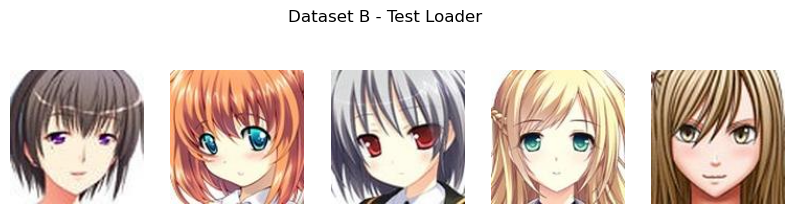

In [15]:
#visualize_data_loader(test_loader_female_B, title="")
visualize_data_loader(test_loader_B, title="Dataset B - Test Loader")



In [16]:
# Load the checkpoints
checkpoint1 = torch.load('/home/shirwee/documents/aps360-project/models/gen_anime_lr0.0003_bs1_epoch_99.pth.tar')
checkpoint2 = torch.load('/home/shirwee/documents/aps360-project/models/gen_human_lr0.0003_bs1_epoch_99.pth.tar')
checkpoint3 = torch.load('/home/shirwee/documents/aps360-project/models/disc_anime_lr0.0003_bs1_epoch_99.pth.tar')
checkpoint4 = torch.load('/home/shirwee/documents/aps360-project/models/disc_human_lr0.0003_bs1_epoch_99.pth.tar')


#Load the state dicts into the models
gen_anime.load_state_dict(checkpoint1["state_dict"])
gen_human.load_state_dict(checkpoint2["state_dict"])
disc_anime.load_state_dict(checkpoint3["state_dict"])
disc_human.load_state_dict(checkpoint4['state_dict'])


<All keys matched successfully>

In [17]:
import torch
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_accuracy(disc_A, disc_B, gen_AtoB, gen_BtoA, test_loader_A, test_loader_B, threshold=0.3):
    gen_AtoB.eval()
    gen_BtoA.eval()
    disc_A.eval()
    disc_B.eval()
    
    total_samples_A = 0
    total_samples_B = 0
    correct_A = 0
    correct_B = 0

    with torch.no_grad():
        for img_A, _ in test_loader_A:
            img_A = img_A.to(device)

            # Generate fake B from A and reconstruct A
            fake_B = gen_AtoB(img_A)
            reconstructed_A = gen_BtoA(fake_B)

            # Calculate reconstruction error
            recon_error_A = F.l1_loss(reconstructed_A, img_A, reduction='none')
            recon_error_A = recon_error_A.mean(dim=(1, 2, 3))

            # Check if reconstruction error is below threshold
            correct_A += torch.sum(recon_error_A < threshold).item()
            total_samples_A += img_A.size(0)

        for img_B, _ in test_loader_B:
            img_B = img_B.to(device)

            # Generate fake A from B and reconstruct B
            fake_A = gen_BtoA(img_B)
            reconstructed_B = gen_AtoB(fake_A)

            # Calculate reconstruction error
            recon_error_B = F.l1_loss(reconstructed_B, img_B, reduction='none')
            recon_error_B = recon_error_B.mean(dim=(1, 2, 3))

            # Check if reconstruction error is below threshold
            correct_B += torch.sum(recon_error_B < threshold).item()
            total_samples_B += img_B.size(0)

    accuracy_A = correct_A / total_samples_A * 100
    accuracy_B = correct_B / total_samples_B * 100

    print(f'Accuracy for domain A: {accuracy_A:.2f}%')
    print("Reconstructed Anime Face")
    print(f'Accuracy for domain B: {accuracy_B:.2f}%')
    print("Reconstructed Human Face")

    return accuracy_A, accuracy_B


In [20]:
accuracy_A, accuracy_B = evaluate_accuracy(disc_anime, disc_human, gen_anime, gen_human, test_loader_A, test_loader_B)

Accuracy for domain A: 89.07%
Reconstructed Anime Face
Accuracy for domain B: 49.60%
Reconstructed Human Face


In [18]:
def get_data_loader_test(data_dir, batch_size, image_size=(128, 128), subset_size=None):
   # Define the transformation
    transform = A.Compose([
        A.Resize(width=image_size[0], height=image_size[1]),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2(),
    ])
    
    # Verify the path
    assert os.path.exists(data_dir), f"Directory not found: {data_dir}"

    # Load the dataset
    dataset = AnimeHumanImageDataset(root_dir=data_dir, transform=transform)

    # Use a subset of the dataset if specified
    num_images = len(dataset)

    # Function to split dataset indices
    test_indices = list(range(num_images))
    test_sampler = SubsetRandomSampler(test_indices)

    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=1)

    return test_loader

In [41]:

gen_anime_loader = get_data_loader_test('/home/shirwee/documents/aps360-project/more_output/outputwnoise/htoa_cropped', BATCH_SIZE, image_size=(120, 122))
gen_human_loader = get_data_loader_test('/home/shirwee/documents/aps360-project/more_output/outputwnoise/atoh_cropped', BATCH_SIZE, image_size=(120, 122))


In [31]:
import torch
import torch.nn as nn
from torchvision.models import inception_v3
import numpy as np
from scipy.linalg import sqrtm

def get_activations(dataloader, model, device):
    """
    Get the activations from the pool3 layer of the inception model.
    """
    model.eval()
    activations = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            pred = model(images)
            activations.append(pred.cpu().numpy())

    activations = np.concatenate(activations, axis=0)
    return activations

def calculate_fid(real_loader, generated_loader, device='cuda'):
    """
    Calculate the FID score between real and generated images.
    """
    # Load the Inception v3 model
    model = inception_v3(pretrained=True)
    model.fc = nn.Identity()  # Remove the final classification layer
    model.to(device)

    # Calculate activations for real and generated images
    act1 = get_activations(real_loader, model, device)
    act2 = get_activations(generated_loader, model, device)

    # Calculate the mean and covariance of the activations
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)

    # Calculate the FID score
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid_value = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid_value

# Example usage
device = 'cuda' if torch.cuda.is_available() else 'cpu'




/home/shirwee/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shirwee/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
fid_value_human = calculate_fid(test_loader_A, gen_human_loader, device)
fid_value_anime = calculate_fid(test_loader_B, gen_anime_loader, device)

/home/shirwee/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shirwee/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


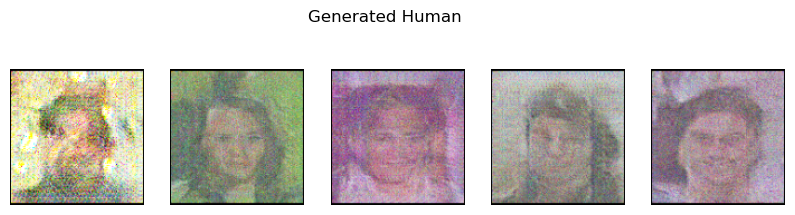

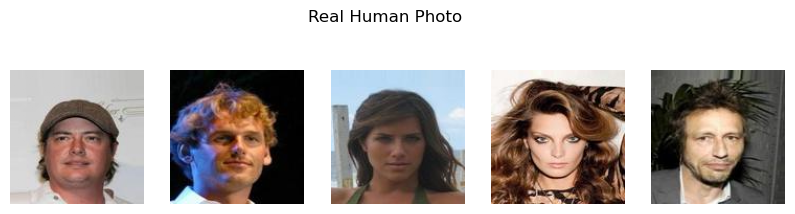

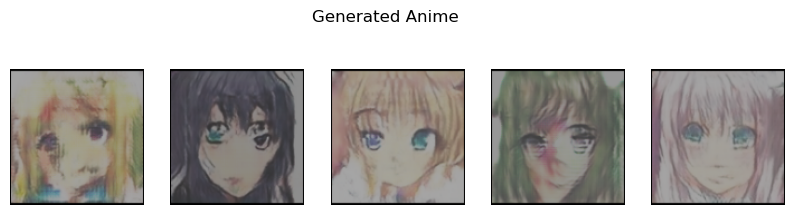

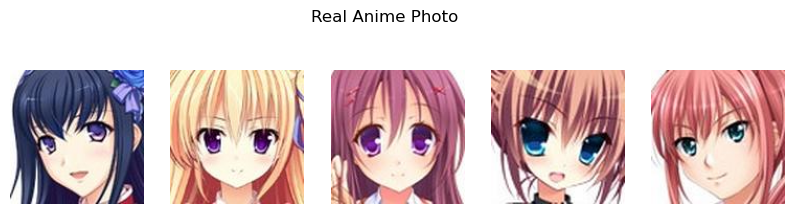

In [42]:
visualize_data_loader(gen_human_loader, "Generated Human")
visualize_data_loader(test_loader_A, "Real Human Photo")

visualize_data_loader(gen_anime_loader, "Generated Anime")
visualize_data_loader(test_loader_B, "Real Anime Photo")

In [45]:
print("FID Score for Anime Images:", fid_value_anime)
print("FID Score for Human Images:", fid_value_human)

FID Score for Anime Images: 1974.6685267236735
FID Score for Human Images: 1223.276756458221


In [50]:
# Load the checkpoints
checkpoint1 = torch.load('/home/shirwee/documents/aps360-project/models/gen_anime_lr0.0003_bs1_epoch_80.pth.tar')
checkpoint2 = torch.load('/home/shirwee/documents/aps360-project/models/gen_human_lr0.0003_bs1_epoch_80.pth.tar')
checkpoint3 = torch.load('/home/shirwee/documents/aps360-project/models/disc_anime_lr0.0003_bs1_epoch_80.pth.tar')
checkpoint4 = torch.load('/home/shirwee/documents/aps360-project/models/disc_human_lr0.0003_bs1_epoch_80.pth.tar')


#Load the state dicts into the models
gen_anime.load_state_dict(checkpoint1["state_dict"])
gen_human.load_state_dict(checkpoint2["state_dict"])
disc_anime.load_state_dict(checkpoint3["state_dict"])
disc_human.load_state_dict(checkpoint4['state_dict'])


<All keys matched successfully>

In [53]:
gen_human.eval()

# Create a directory to save the outputs
output_dir = '/home/shirwee/documents/aps360-project/outputs/A'
os.makedirs(output_dir, exist_ok=True)

# Loop through the test data
for i, (inputs, _) in enumerate(train_loader_A):
    # Move inputs to the same device as the model
    inputs = inputs.to(device)

    # Get the model's outputs
    with torch.no_grad():
        outputs = gen_human(inputs)

    # Save the outputs
    for j in range(outputs.size(0)):
        save_image(outputs[j], os.path.join(output_dir, f'output_{i * train_loader_A.batch_size + j}.png'))


KeyboardInterrupt: 